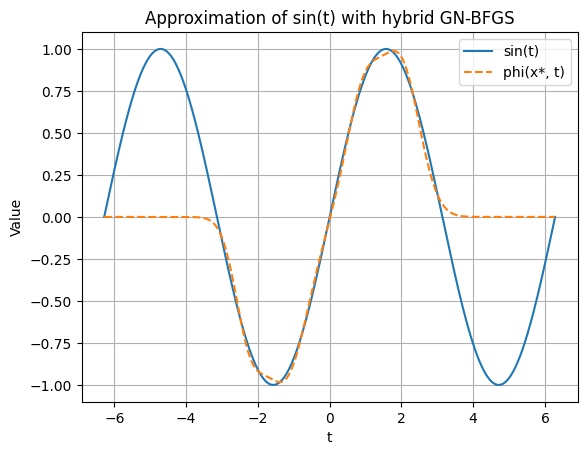

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import line_search

# Constants
l = 4
m = 100
a_vals = np.linspace(-2 * np.pi, 2 * np.pi, m)
b_vals = np.sin(a_vals)

# ================================
# Gaussian model and its Jacobian
# ================================

def phi(x, t_vals):
    result = np.zeros_like(t_vals)
    for i in range(l):
        alpha = x[3 * i]
        mu = x[3 * i + 1]
        sigma = x[3 * i + 2]
        result += alpha * np.exp(-((t_vals - mu) ** 2) / (2 * sigma ** 2))
    return result

def residual(x):
    return phi(x, a_vals) - b_vals

def jacobian(x):
    J = np.zeros((m, 3 * l))
    for j, t in enumerate(a_vals):
        for i in range(l):
            alpha = x[3 * i]
            mu = x[3 * i + 1]
            sigma = x[3 * i + 2]
            exp_term = np.exp(-((t - mu) ** 2) / (2 * sigma ** 2))
            d_alpha = exp_term
            d_mu = alpha * exp_term * (t - mu) / (sigma ** 2)
            d_sigma = alpha * exp_term * ((t - mu) ** 2) / (sigma ** 3)
            J[j, 3 * i] = d_alpha
            J[j, 3 * i + 1] = d_mu
            J[j, 3 * i + 2] = d_sigma
    return J

# ======================
# Hybrid GN-BFGS method
# ======================

def hybrid_gn_bfgs(x0, max_iter=100, tol=1e-6):
    x = x0.copy()
    r = residual(x)
    J = jacobian(x)
    H = J.T @ J  # Initial GN approximation
    g = J.T @ r

    history = [x.copy()]

    for k in range(max_iter):
        # Solve for descent direction
        try:
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            print("Hessian not invertible.")
            break

        # Backtracking line search (Armijo)
        alpha = 1.0
        c = 1e-4
        rho = 0.5
        f0 = 0.5 * np.dot(r, r)
        while True:
            x_new = x + alpha * p
            r_new = residual(x_new)
            f_new = 0.5 * np.dot(r_new, r_new)
            if f_new <= f0 + c * alpha * np.dot(g, p):
                break
            alpha *= rho

        s = alpha * p
        x += s
        r_new = residual(x)
        J_new = jacobian(x)
        g_new = J_new.T @ r_new
        y = g_new - g

        # BFGS update
        ys = y @ s
        if ys > 1e-10:  # ensure positive definiteness
            Hs = H @ s
            H += np.outer(y, y) / ys - np.outer(Hs, Hs) / (s @ Hs)

        g = g_new
        r = r_new
        J = J_new
        history.append(x.copy())

        if np.linalg.norm(g) < tol:
            break

    return x, history

# ==================================
# Run an example with visualization
# ==================================
np.random.seed(42)
x0 = np.random.randn(3 * l)  # Random initial guess
x_star, history = hybrid_gn_bfgs(x0)

# Plot final result
t_vals_plot = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
plt.plot(t_vals_plot, np.sin(t_vals_plot), label='sin(t)')
plt.plot(t_vals_plot, phi(x_star, t_vals_plot), label='phi(x*, t)', linestyle='--')
plt.legend()
plt.title('Approximation of sin(t) with hybrid GN-BFGS')
plt.xlabel('t')
plt.ylabel('Value')
plt.grid(True)
plt.show()


5 Runs:

In [3]:
import time

np.random.seed(42)

def evaluate_runs(x_star, num_runs=5, scales=[0.5, 1.0, 1.5, 2.0, 3.0]):
    for i, scale in enumerate(scales[:num_runs]):
        print(f"\n--- Run {i + 1} (scale = {scale}) ---")
        x0 = np.random.randn(3 * l) * scale
        start_time = time.time()
        x_final, history = hybrid_gn_bfgs(x0)
        end_time = time.time()
        runtime = end_time - start_time

        distance = np.linalg.norm(x_final - x_star)
        k = len(history) - 2
        if k < 0:
            print("Insufficient iterations for convergence analysis.")
            continue

        xk = history[k]
        xk1 = history[k + 1]
        lk = np.linalg.norm(xk1 - x_star) / np.linalg.norm(xk - x_star)
        qk = np.linalg.norm(xk1 - x_star) / (np.linalg.norm(xk - x_star) ** 2)

        print(f"Stopping criterion: ||g|| < 1e-6 or max_iter = 100")
        print(f"Final iterate x̄:\n{x_final}")
        print(f"Distance to x*: {distance:.6f}")
        print(f"ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = {lk:.6f}")
        print(f"q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = {qk:.6f}")
        print(f"Runtime: {runtime:.4f} seconds")

        # Plotting result
        plt.figure()
        plt.plot(a_vals, b_vals, label="sin(t)")
        plt.plot(a_vals, phi(x_final, a_vals), '--', label="phi(x̄; t)")
        plt.title(f"Run {i + 1}: phi(x̄; t) vs sin(t)")
        plt.xlabel("t")
        plt.ylabel("Function value")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"run_{i+1}_plot.png")  # Save plot as PNG
        plt.show()



--- Run 1 (scale = 0.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-0.5261078  -2.2525522  -0.40857758 -0.94105944 -1.25548743  0.64933059
  0.9410741   1.25548861 -0.64932171  0.52611754  2.25260305 -0.40855999]
Distance to x*: 14.542756
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.000002
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.068763
Runtime: 0.3184 seconds


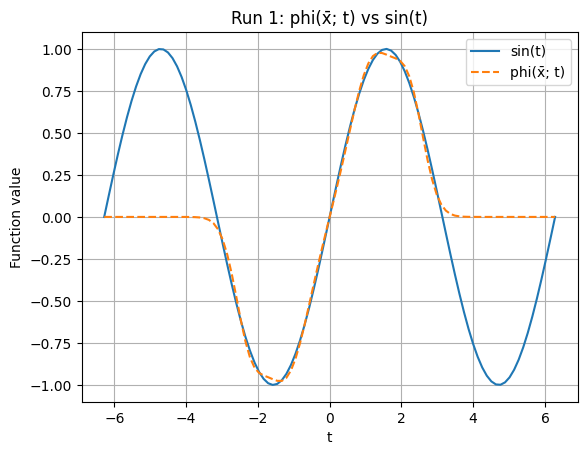


--- Run 2 (scale = 1.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-4.91701867e+05 -1.73274111e+06  1.58367317e+05 -1.32070606e+00
 -1.57082946e+00  8.02799438e-01  9.37105612e+04  3.91456354e+05
  5.30244779e+04  5.27239229e+05  1.21545607e+06  2.23874996e+05]
Distance to x*: 2289001.808655
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.040291
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.000000
Runtime: 0.2726 seconds


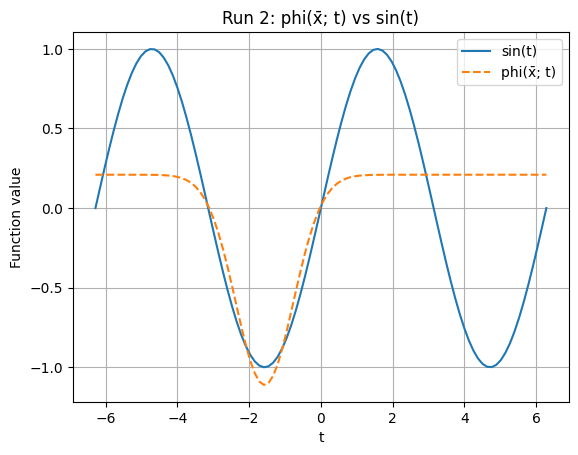


--- Run 3 (scale = 1.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-0.89887765  0.19439239 -1.73245496  0.56349903 -0.90096337 -0.43749907
  2.92157496  2.76566055 -0.02944755 -1.51108919  1.27416811 -1.82582634]
Distance to x*: 15.715177
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.000000
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.063633
Runtime: 0.9595 seconds


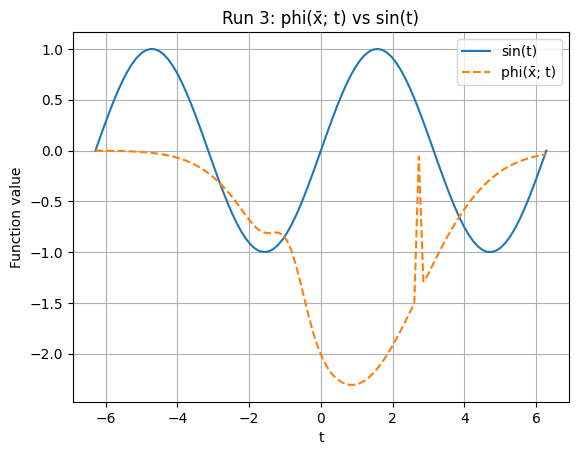


--- Run 4 (scale = 2.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 1.17120896 -4.51275505  0.59449592  1.01980865  1.52979106  0.88637389
 -1.09527779  4.68068167 -0.81832311 -1.02420142 -1.51196971  0.8701816 ]
Distance to x*: 13.183754
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 0.999530
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.075780
Runtime: 0.2829 seconds


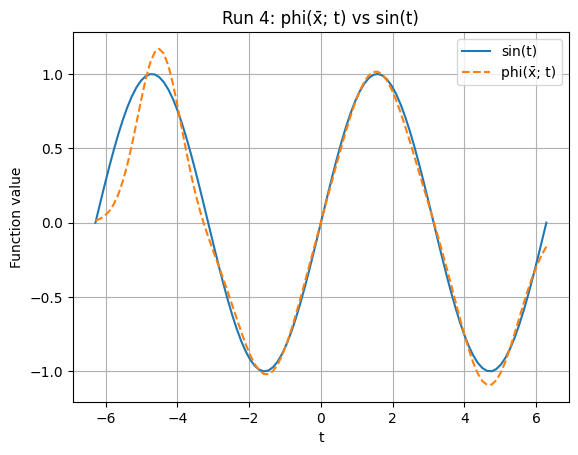


--- Run 5 (scale = 3.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 4.3461863  -4.45403748  1.66961207 -5.60374854  4.52716428  1.77688031
  4.64464317  4.23630319 -2.64741119 -3.44329898 -3.92072968 -2.69820486]
Distance to x*: 17.619093
ℓ_k = ||x_(k+1) - x*|| / ||x_k - x*|| = 1.004853
q_k = ||x_(k+1) - x*|| / ||x_k - x*||^2 = 0.057309
Runtime: 0.2019 seconds


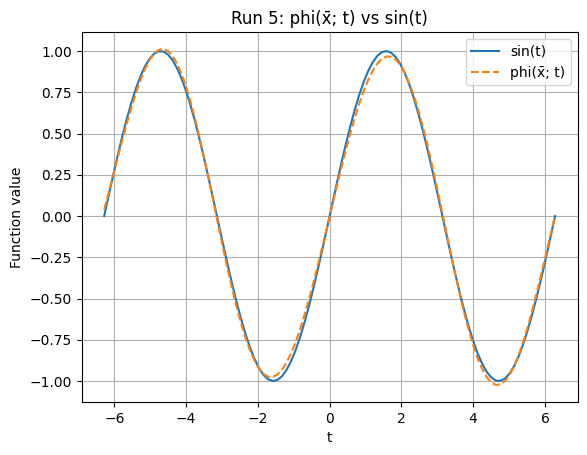

In [4]:
np.random.seed(42)
evaluate_runs(x_star)


Comparison with standard Newton Method:


=== Run 1 with scale 0.1 ===
GN-BFGS: Obj=0.253846, Dist=34.070659, Time=0.2871s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=0.393648, Dist=0.598728, Time=3.5108s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


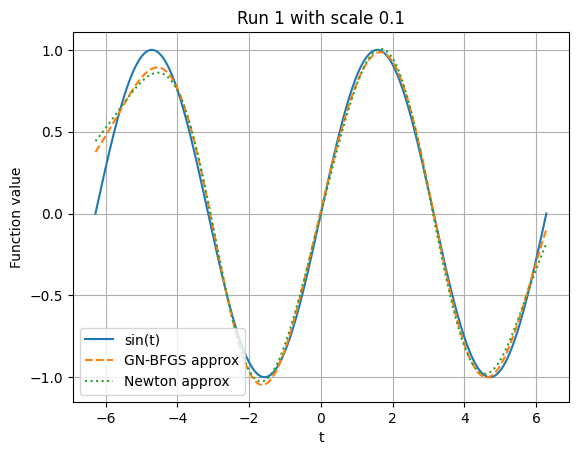


=== Run 2 with scale 0.25 ===
GN-BFGS: Obj=0.258627, Dist=27.456523, Time=0.2784s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=1.878194, Dist=1.496686, Time=3.3807s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


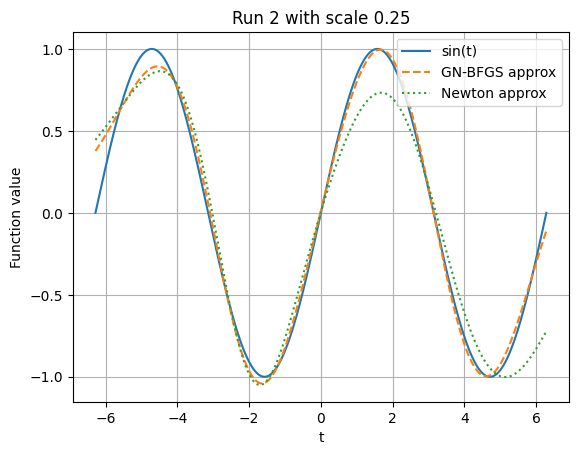


=== Run 3 with scale 0.5 ===
GN-BFGS: Obj=0.270602, Dist=19.662959, Time=0.2572s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=3.805681, Dist=4.491276, Time=3.4833s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


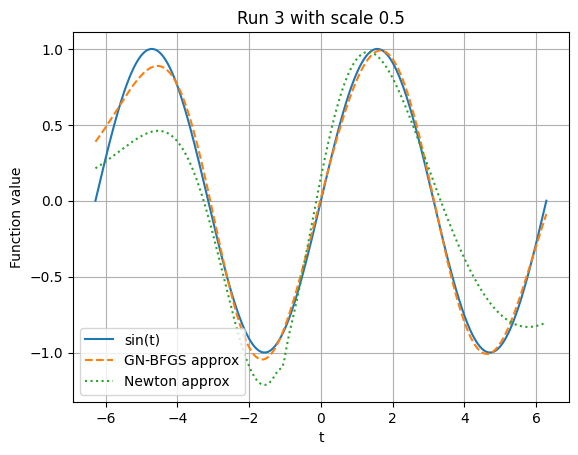


=== Run 4 with scale 0.75 ===
GN-BFGS: Obj=0.051759, Dist=10.470012, Time=0.2804s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=24.116171, Dist=6.539296, Time=3.6842s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


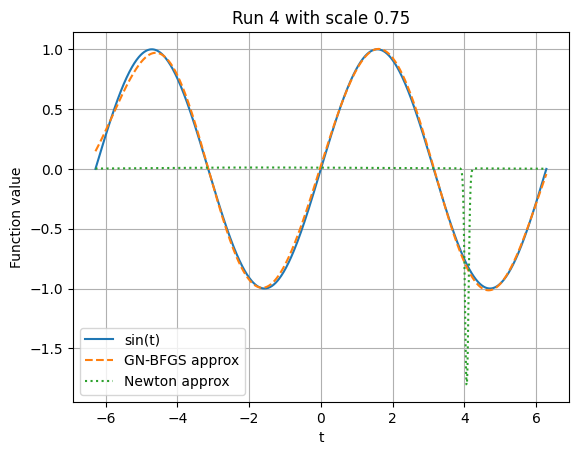


=== Run 5 with scale 1.0 ===
GN-BFGS: Obj=0.058716, Dist=18.232787, Time=0.2741s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=0.951341, Dist=3.049949, Time=3.2632s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


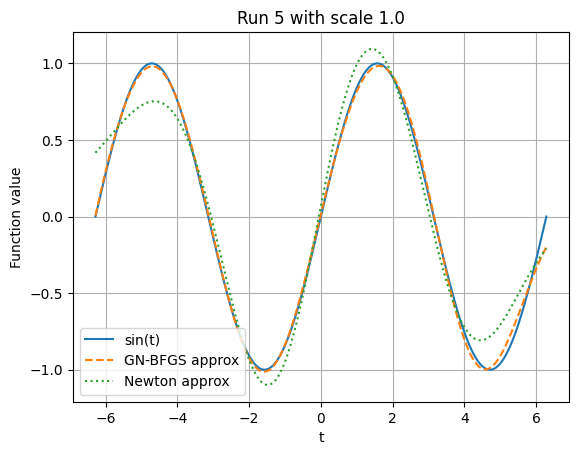


=== Run 6 with scale 1.5 ===
GN-BFGS: Obj=12.548899, Dist=71877.972305, Time=0.2488s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=24.140772, Dist=13.153918, Time=3.7989s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


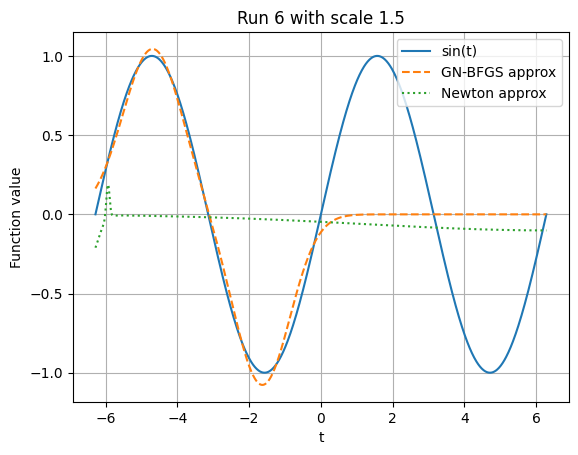


=== Run 7 with scale 2.0 ===
GN-BFGS: Obj=7.504751, Dist=40.511981, Time=0.2472s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=22.067243, Dist=13.084049, Time=3.3732s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


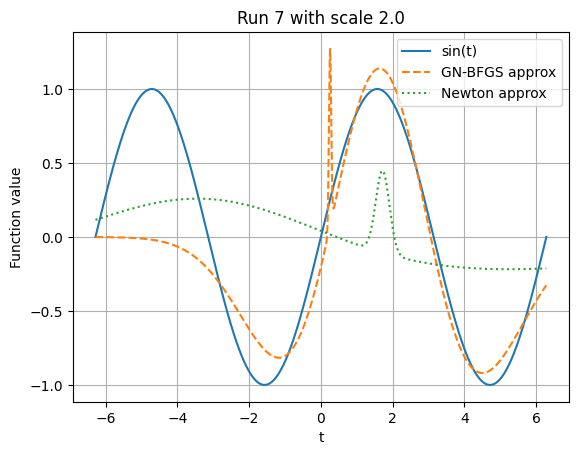


=== Run 8 with scale 2.5 ===
GN-BFGS: Obj=21.033814, Dist=727.076936, Time=0.2649s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=24.325935, Dist=11.609055, Time=3.6265s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


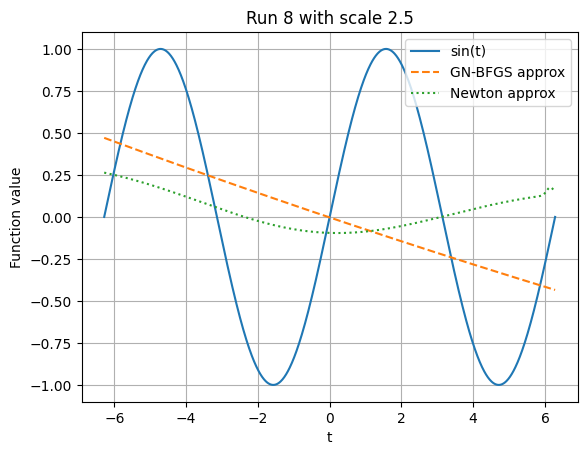


=== Run 9 with scale 3.0 ===
GN-BFGS: Obj=0.834100, Dist=4117.577835, Time=0.2579s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=25.652416, Dist=9.370436, Time=3.8083s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


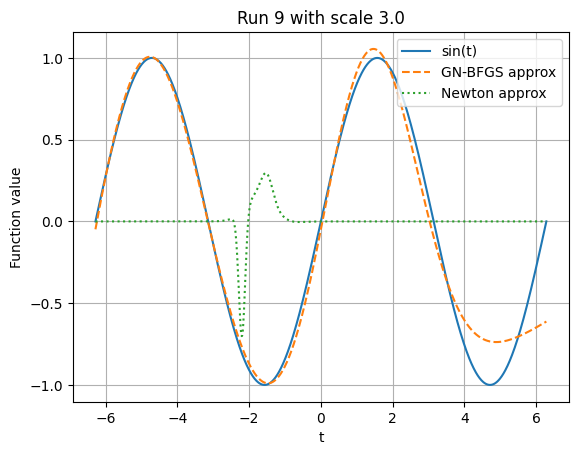


=== Run 10 with scale 4.0 ===
GN-BFGS: Obj=0.066662, Dist=28.225286, Time=0.2554s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0
Newton: Obj=19.004198, Dist=11.976346, Time=3.5052s, Convergence rates: Linear=4, Superlinear=0, Quadratic=0


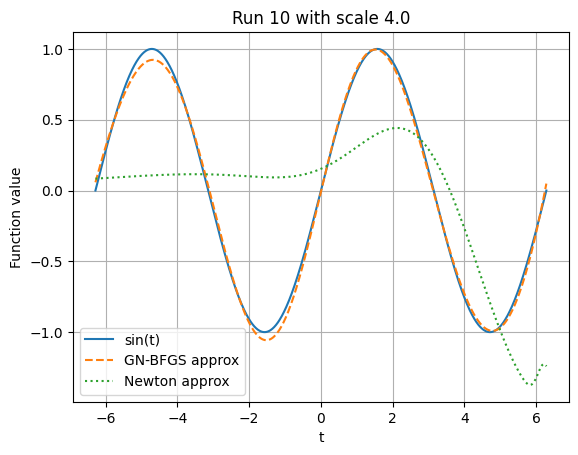


Average GN-BFGS runtime over 10 runs: 0.2651 seconds
Average Newton runtime over 10 runs: 3.5434 seconds


In [7]:
from scipy.optimize import approx_fprime
import time

np.random.seed(42)

def objective_function(x):
    r = residual(x)
    return 0.5 * np.dot(r, r)

def numerical_hessian(f, x, epsilon=1e-5):
    n = len(x)
    hess = np.zeros((n, n))
    fx = f(x)
    for i in range(n):
        x1 = x.copy()
        x1[i] += epsilon
        grad1 = approx_fprime(x1, f, epsilon)
        x2 = x.copy()
        x2[i] -= epsilon
        grad2 = approx_fprime(x2, f, epsilon)
        hess[:, i] = (grad1 - grad2) / (2 * epsilon)
    return (hess + hess.T) / 2  # Make symmetric

def newton_method(x0, max_iter=100, tol=1e-6):
    x = x0.copy()
    history = [x.copy()]

    for k in range(max_iter):
        r = residual(x)
        J = jacobian(x)
        g = J.T @ r
        if np.linalg.norm(g) < tol:
            break

        H = numerical_hessian(objective_function, x)

        try:
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            print("Hessian not invertible.")
            break

        # Line search
        alpha = 1.0
        c = 1e-4
        rho = 0.5
        f0 = objective_function(x)
        while True:
            x_new = x + alpha * p
            f_new = objective_function(x_new)
            if f_new <= f0 + c * alpha * g @ p:
                break
            alpha *= rho

        x += alpha * p
        history.append(x.copy())

    return x, history

def classify_convergence(history, x_star):
    linear_counts = 0
    superlinear_counts = 0
    quadratic_counts = 0
    n = len(history)

    # We analyze the last few steps, say last 5 steps (if available)
    start_idx = max(0, n - 6)

    for k in range(start_idx, n - 2):
        xk = history[k]
        xk1 = history[k + 1]
        xk2 = history[k + 2]

        dist_k = np.linalg.norm(xk - x_star)
        dist_k1 = np.linalg.norm(xk1 - x_star)
        dist_k2 = np.linalg.norm(xk2 - x_star)

        if dist_k == 0 or dist_k1 == 0:
            continue

        # Linear ratio
        ell_k = dist_k1 / dist_k
        # Quadratic ratio
        q_k = dist_k2 / (dist_k1 ** 2)

        # Classify
        # Thresholds can be tuned depending on your problem
        if ell_k < 0.9:
            if 0.1 < q_k < 10:
                quadratic_counts += 1
            else:
                superlinear_counts += 1
        else:
            linear_counts += 1

    return linear_counts, superlinear_counts, quadratic_counts


def evaluate_both_methods(x_star, scales):
    np.random.seed(42)  # For reproducibility

    times_gn = []
    times_newton = []

    for i, scale in enumerate(scales):
        print(f"\n=== Run {i+1} with scale {scale} ===")

        x0 = x_star + np.random.randn(3 * l) * scale

        # Hybrid GN-BFGS
        start = time.time()
        x_gn, hist_gn = hybrid_gn_bfgs(x0)
        time_gn = time.time() - start
        times_gn.append(time_gn)

        obj_gn = objective_function(x_gn)
        dist_gn = np.linalg.norm(x_gn - x_star)

        # Compute convergence rates for GN-BFGS
        lin_gn, superlin_gn, quad_gn = classify_convergence(hist_gn, x_star)

        # Newton method
        start = time.time()
        try:
            x_newton, hist_newton = newton_method(x0)
            newton_failed = False
        except Exception as e:
            print(f"Newton failed with error: {e}")
            x_newton = None
            hist_newton = []
            newton_failed = True
        time_newton = time.time() - start
        if not newton_failed:
            times_newton.append(time_newton)

        if not newton_failed:
            obj_newton = objective_function(x_newton)
            dist_newton = np.linalg.norm(x_newton - x_star)
            lin_newton, superlin_newton, quad_newton = classify_convergence(hist_newton, x_star)
        else:
            obj_newton = None
            dist_newton = None
            lin_newton = superlin_newton = quad_newton = None

        print(f"GN-BFGS: Obj={obj_gn:.6f}, Dist={dist_gn:.6f}, Time={time_gn:.4f}s, "
              f"Convergence rates: Linear={lin_gn}, Superlinear={superlin_gn}, Quadratic={quad_gn}")

        if not newton_failed:
            print(f"Newton: Obj={obj_newton:.6f}, Dist={dist_newton:.6f}, Time={time_newton:.4f}s, "
                  f"Convergence rates: Linear={lin_newton}, Superlinear={superlin_newton}, Quadratic={quad_newton}")
        else:
            print(f"Newton method failed to converge.")

        # Plot results for this run
        t_plot = np.linspace(-2*np.pi, 2*np.pi, 1000)
        plt.plot(t_plot, np.sin(t_plot), label='sin(t)')
        plt.plot(t_plot, phi(x_gn, t_plot), '--', label='GN-BFGS approx')
        if not newton_failed:
            plt.plot(t_plot, phi(x_newton, t_plot), ':', label='Newton approx')
        plt.title(f"Run {i+1} with scale {scale}")
        plt.xlabel("t")
        plt.ylabel("Function value")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"run_{i+1}_scale_{scale}.png")
        plt.show()

    # After all runs, compute and print average runtimes
    avg_time_gn = sum(times_gn) / len(times_gn) if times_gn else 0
    avg_time_newton = sum(times_newton) / len(times_newton) if times_newton else 0

    print(f"\nAverage GN-BFGS runtime over {len(times_gn)} runs: {avg_time_gn:.4f} seconds")
    print(f"Average Newton runtime over {len(times_newton)} runs: {avg_time_newton:.4f} seconds")


x0 = np.random.randn(3 * l)
for i in range(l):
    x0[3*i + 2] = np.abs(x0[3*i + 2]) + 0.1  # make sure sigma > 0.1 initially
x_star_approx, _ = hybrid_gn_bfgs(x0)
scales = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]

evaluate_both_methods(x_star_approx, scales)


